In [1]:
import pandas as pd
from nilearn import datasets
import nibabel as nib
import numpy as np
import ast
import math
from IPython.core.debugger import Tracer
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def distance(p0, p1):
    return math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2 + (p0[2]-p1[2])**2)

- Get Data and regions, horizontally stack
- for each observation get the coordinates in mm and -- 
- 

In [3]:
data=pd.read_csv('../data_meta_analysis/Data_Classifications_v7.csv')
#data.head()

R1= pd.read_csv("../data_meta_analysis/data_derived_meta_analysis/X_region1_before_clustering_2.csv")
R1.head()

,Frontal_Sup_L,Frontal_Sup_R,Frontal_Sup_Orb_L,Frontal_Sup_Orb_R,Frontal_Mid_L,Frontal_Mid_R,Frontal_Mid_Orb_L,Frontal_Mid_Orb_R,Frontal_Inf_Oper_L,Frontal_Inf_Oper_R,...,Frontal_Sup_Medial_L,Frontal_Sup_Medial_R,Insula_L,Insula_R,Cingulum_Ant_L,Cingulum_Ant_R,Cingulum_Mid_L,Cingulum_Mid_R,Precentral_L,Precentral_R
0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


In [4]:
data_simple =pd.concat((data[['PID','Info.type','MNI.Coordinates']],R1),axis=1)
data_simple.head()

,PID,Info.type,MNI.Coordinates,Frontal_Sup_L,Frontal_Sup_R,Frontal_Sup_Orb_L,Frontal_Sup_Orb_R,Frontal_Mid_L,Frontal_Mid_R,Frontal_Mid_Orb_L,...,Frontal_Sup_Medial_L,Frontal_Sup_Medial_R,Insula_L,Insula_R,Cingulum_Ant_L,Cingulum_Ant_R,Cingulum_Mid_L,Cingulum_Mid_R,Precentral_L,Precentral_R
0,93,Perceptual,NaN,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
1,93,Perceptual,NaN,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
2,93,Perceptual,NaN,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
3,93,Perceptual,NaN,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
4,93,Perceptual,NaN,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


In [5]:
# get AAL atlas
dataset = datasets.fetch_atlas_aal()
atlas_filename = dataset.maps
atlas_img = nib.load(dataset.maps)
atlas_img_data = atlas_img.get_data()

In [6]:
def give_center_of_region_by_name(region_name,dataset=dataset,atlas_img=atlas_img,atlas_img_data=atlas_img_data):


    
    # get region number
    index2 = np.array([d==region_name for d in dataset.labels])
    index = np.array(dataset.indices)[index2][0]
    #print(region_name)
    #print(index)

    # get all coordinates for the regions
    where = np.where(atlas_img_data==np.float(index))

    coords_in_matrix = np.vstack((where[0],where[1],where[2],np.ones((1,len(where[0])))[0,:]))
    
    # convert to MNI
    coords_in_aal = np.empty(coords_in_matrix.shape)
    for c in range(coords_in_matrix.shape[1]):
        coords_in_aal[:,c] = np.dot(atlas_img.affine,coords_in_matrix[:,c])

    # calculate centroid, just the mean along each axis 
    center = np.mean(coords_in_aal,axis=1)
    return(center)

In [7]:
print(give_center_of_region_by_name(region_name='Frontal_Sup_Medial_L'))
print(give_center_of_region_by_name(region_name='Precentral_L'))

[ -5.17379679  47.88703209  29.63636364   1.        ]
[-38.93023256  -6.96142938  49.64038571   1.        ]


## Single DataFrame with Studies with only single region per observation

In [8]:
### put coordinates in the data-frame (only for single region observations for now)

for row_num in range(R1.shape[0]):
    R1.loc[row_num,:]==1
    r = R1.loc[row_num,:]==1
    regions_for_observation = list(r.index[R1.loc[row_num,:]==1])
    #print(regions_for_observation)
    #print(len(regions_for_observation))
    # if observation has just one region 
    if len(regions_for_observation)==1:
        region = regions_for_observation[0]
        if type(data_simple.loc[row_num]['MNI.Coordinates']) is str:
            #print('yes')
            test = data_simple.loc[row_num]['MNI.Coordinates']
            test = test.replace('_','')
            test = test.replace('\x05','')
            test = test.split(';')[0]
            if len(test.split(';'))>1:
                print('checking')
            center = [np.float(test.split(',')[i]) for i in range(3)]
            center2 = center
        else:
            center = give_center_of_region_by_name(region_name=region)[:,np.newaxis]
            center = list(center[:,0:3].flatten())[0:3] # just make a [x,y,z] list
            center1 = center
        data_simple.loc[row_num,'centroid']=str(center)
    else:
        data_simple.loc[row_num,'centroid']='NaN'
    # more than one aal 
#     centers = np.ones((4,1))
#     for region in regions_for_observation:
#         center = give_center_of_region_by_name(region_name=region)[:,np.newaxis]
#         centers = np.hstack((centers,center))
#     centers = centers[:,1::]

In [9]:
type(center2[1])

float

In [10]:
type(center1[1])

numpy.float64

In [11]:
data_simple_one_region = data_simple.loc[data_simple.centroid!='NaN',]
data_simple_one_region.head()

#data_simple.centroid

,PID,Info.type,MNI.Coordinates,Frontal_Sup_L,Frontal_Sup_R,Frontal_Sup_Orb_L,Frontal_Sup_Orb_R,Frontal_Mid_L,Frontal_Mid_R,Frontal_Mid_Orb_L,...,Frontal_Sup_Medial_R,Insula_L,Insula_R,Cingulum_Ant_L,Cingulum_Ant_R,Cingulum_Mid_L,Cingulum_Mid_R,Precentral_L,Precentral_R,centroid
22,87,Perceptual,"3,53,-20",0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[3.0, 53.0, -20.0]"
23,87,Perceptual,"60,17,34",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[60.0, 17.0, 34.0]"
24,87,Perceptual,"3,53,-20",0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,"[3.0, 53.0, -20.0]"
25,87,Perceptual,"60,17,34",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[60.0, 17.0, 34.0]"
27,80,Perceptual,"0, 23, 39",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0.0, 23.0, 39.0]"


In [12]:
#data_simple_one_region.iloc[:,2:-1].sum


In [13]:

def get_distance_matrix_for_study(PID,data_simple_one_region):
    #print(PID)
    study_data = data_simple_one_region.loc[data_simple_one_region.PID==PID,'centroid']

    study_data_regions = data_simple_one_region.loc[data_simple_one_region.PID==PID,:]
    study_data_regions = study_data_regions.iloc[:,3:29]
    # find number of ROIs used in a study 
    d= data_simple_one_region.loc[data_simple_one_region.PID==PID,]
    #print(d)
    n_rois = d.iloc[:,3:-1].max(0).sum() # find a 1 first along different analyses, and then sum across ROI's

    
    distance_matrix = np.zeros((len(study_data),len(study_data)))
    distance_matrix_names = np.chararray((len(study_data),len(study_data)),itemsize=100)
    
    for i in range(len(study_data)):
        for j in range(len(study_data)):
            p0 = np.array(ast.literal_eval(study_data.iloc[i]))

            p0_row = study_data_regions.iloc[i,:]
            p0_region_name = study_data_regions.columns[p0_row==1][0]

            p1 = np.array(ast.literal_eval(study_data.iloc[j]))
            p1_row = study_data_regions.iloc[j,:]
            p1_region_name = study_data_regions.columns[p1_row==1][0]
            distance_matrix[i,j]=distance(p0,p1)
            distance_matrix_names[i,j]=p0_region_name+'--'+p1_region_name

    # get the upper triangular indices
    iu1 = np.triu_indices(np.shape(distance_matrix)[0])
    # set to -1 
    distance_matrix[iu1]=-1
    # get all other distances #
    distances = distance_matrix[distance_matrix!=-1]
    
    n_analyses_per_study=len(study_data)
    
    return(distances,distance_matrix,n_analyses_per_study,n_rois,distance_matrix_names)

    

In [14]:
get_distance_matrix_for_study(6,data_simple_one_region)

(array([ 88.89319434,  39.23009049,  54.41507144,  14.        ,
         76.90253572,  28.47806173]),
 array([[ -1.        ,  -1.        ,  -1.        ,  -1.        ],
        [ 88.89319434,  -1.        ,  -1.        ,  -1.        ],
        [ 39.23009049,  54.41507144,  -1.        ,  -1.        ],
        [ 14.        ,  76.90253572,  28.47806173,  -1.        ]]),
 4,
 4,
 chararray([['Frontal_Inf_Orb_L--Frontal_Inf_Orb_L',
         'Frontal_Inf_Orb_L--Frontal_Sup_L',
         'Frontal_Inf_Orb_L--Frontal_Inf_Oper_L',
         'Frontal_Inf_Orb_L--Frontal_Inf_Tri_L'],
        ['Frontal_Sup_L--Frontal_Inf_Orb_L', 'Frontal_Sup_L--Frontal_Sup_L',
         'Frontal_Sup_L--Frontal_Inf_Oper_L',
         'Frontal_Sup_L--Frontal_Inf_Tri_L'],
        ['Frontal_Inf_Oper_L--Frontal_Inf_Orb_L',
         'Frontal_Inf_Oper_L--Frontal_Sup_L',
         'Frontal_Inf_Oper_L--Frontal_Inf_Oper_L',
         'Frontal_Inf_Oper_L--Frontal_Inf_Tri_L'],
        ['Frontal_Inf_Tri_L--Frontal_Inf_Orb_L',
         '

In [15]:
import seaborn as sns

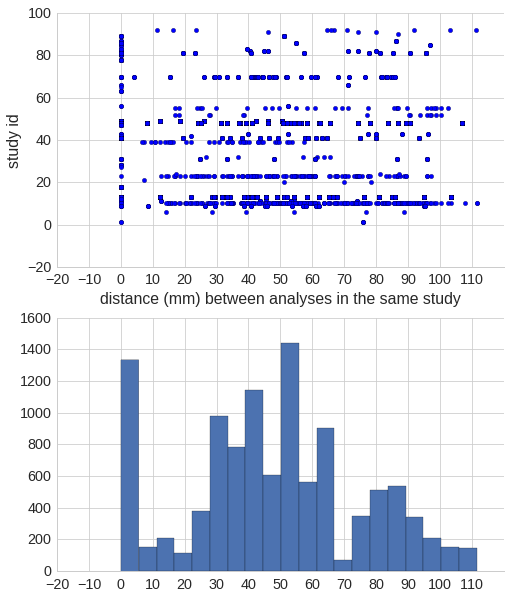

In [16]:

    
sns.set_context('paper',font_scale=1.8)
sns.set_style('whitegrid',{'figure.facecolor':'white'})

# total storage for histogram 
all_distances = np.array([])

number_sharing_an_roi=np.empty(len(data_simple_one_region.PID.unique()))
total_num=np.empty(len(data_simple_one_region.PID.unique()))

n_obs=np.empty(len(data_simple_one_region.PID.unique()))
n_rois=np.empty(len(data_simple_one_region.PID.unique()))

f,axarray=plt.subplots(2,1,figsize=(8,10),sharex=False)

PIDs = np.array([])

# loop through studies with one region and print 
for pid,PID in enumerate(data_simple_one_region.PID.unique()):

    single_study_distances,_,n_obs[pid],n_rois[pid],_ = get_distance_matrix_for_study(PID,data_simple_one_region)
    
    # scatter plot 
    axarray[0].scatter(single_study_distances,np.ones(len(single_study_distances))*PID);
    
    # store all distances. 
    all_distances = np.append(all_distances,single_study_distances)
    
    #calculate the percentage of 0-distance per study 
    number_sharing_an_roi[pid] = np.sum(single_study_distances==0)
    total_num[pid] = len(single_study_distances)
    
    PIDs = np.append(PIDs,PID)
    


axarray[1].hist(all_distances,20);
axarray[0].set_ylabel('study id')

axarray[0].set_xlabel('distance (mm) between analyses in the same study')
start, end = axarray[0].get_xlim()
axarray[1].set_xticks(np.arange(start,end,10))
axarray[0].set_xticks(np.arange(start,end,10))

sns.despine()

plt.savefig('../Figures/Supp/withinstudy_distances_using_coordinates.png')

Why are there two observations with inbetween 0-10mm? 

In [17]:
distances,distance_matrix,n_analyses_per_study,_,distance_matrix_names=get_distance_matrix_for_study(44,data_simple_one_region)
### finding speficic pairwise combo 
#distance_matrix_names[np.round(distance_matrix,2)==3.6]
#disances

In [18]:
p0=give_center_of_region_by_name(region_name='Frontal_Inf_Orb_R')
p1=give_center_of_region_by_name(region_name='Frontal_Mid_R')
print(p0)
print(p1)
print(distance(p0,p1))

[ 40.91036907  30.99472759 -13.25834798   1.        ]
[ 37.39184953  31.7507837   32.81426332   1.        ]
46.2129539496


# Within Study Percent of Pairwise Distances

In [19]:
total = len(all_distances) 
print(2000.0/total)
print(1000.0/total)

0.182982616651
0.0914913083257


In [20]:
np.vstack((number_sharing_an_roi,total_num,)).astype('int').T

array([[   6,   15],
       [   6,    6],
       [   2,    6],
       [   0,    0],
       [   6,    6],
       [   0,    0],
       [   2,    6],
       [   0,   28],
       [   0,    0],
       [   0,   15],
       [   0,    0],
       [   4,   28],
       [   0,    0],
       [   0,    6],
       [  15,   15],
       [   1,  120],
       [   8,   36],
       [   2,  276],
       [   0,    6],
       [   0,    3],
       [   2,    6],
       [   4,   28],
       [  15,   15],
       [  60,  276],
       [ 528, 4560],
       [   0,    3],
       [ 508, 4560],
       [   2,    6],
       [   1,    1],
       [   2,    6],
       [  10,  190],
       [   1,    1],
       [   0,    0],
       [   0,    0],
       [  15,   15],
       [   1,    3],
       [  44,  325],
       [  12,   66],
       [   1,    1],
       [   0,    0],
       [   0,    1],
       [   0,    3],
       [  28,   28],
       [   3,    3],
       [   6,   66],
       [   0,   10],
       [   0,    1],
       [  12,

In [21]:
total_num.astype('int')

array([  15,    6,    6,    0,    6,    0,    6,   28,    0,   15,    0,
         28,    0,    6,   15,  120,   36,  276,    6,    3,    6,   28,
         15,  276, 4560,    3, 4560,    6,    1,    6,  190,    1,    0,
          0,   15,    3,  325,   66,    1,    0,    1,    3,   28,    3,
         66,   10,    1,   28,   15,  105,    0,    0,   36])

In [22]:
number_sharing_an_roi/total_num

array([ 0.4       ,  1.        ,  0.33333333,         nan,  1.        ,
               nan,  0.33333333,  0.        ,         nan,  0.        ,
               nan,  0.14285714,         nan,  0.        ,  1.        ,
        0.00833333,  0.22222222,  0.00724638,  0.        ,  0.        ,
        0.33333333,  0.14285714,  1.        ,  0.2173913 ,  0.11578947,
        0.        ,  0.11140351,  0.33333333,  1.        ,  0.33333333,
        0.05263158,  1.        ,         nan,         nan,  1.        ,
        0.33333333,  0.13538462,  0.18181818,  1.        ,         nan,
        0.        ,  0.        ,  1.        ,  1.        ,  0.09090909,
        0.        ,  0.        ,  0.42857143,  0.46666667,  0.14285714,
               nan,         nan,  0.        ])

In [23]:
x = np.arange(1,pid)

print(len(total_num.astype('int')))

53


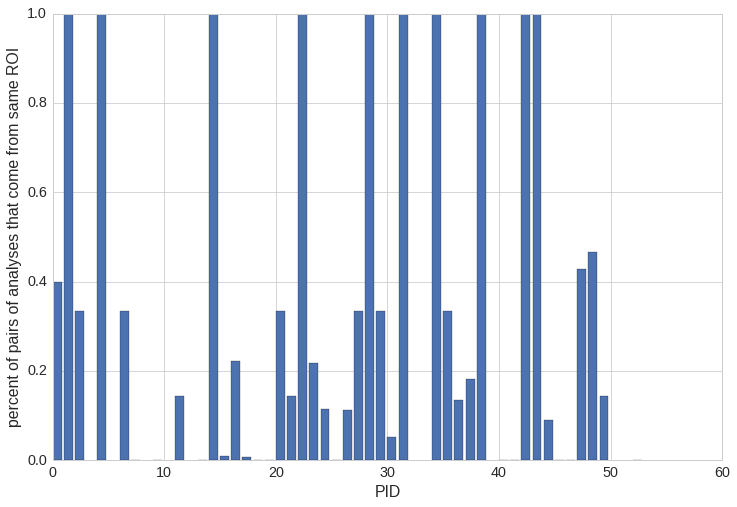

In [24]:
f,axarray=plt.subplots(1,1,figsize=(12,8))
x = np.arange(0,len(total_num))
y = total_num.astype('int')
y = number_sharing_an_roi/total_num
axarray.bar(x,y)
axarray.set_xlabel('PID')
axarray.set_ylabel('percent of pairs of analyses that come from same ROI')
plt.savefig('../Figures/Supp/withinstudy_distances_percent_pairs_same_ROI.png')

In [25]:
np.mean(y==1)

0.18867924528301888

# Number of Total Analyses per study - Percent Different ROIs

In [26]:
n_obs

array([  6.,   4.,   4.,   1.,   4.,   1.,   4.,   8.,   1.,   6.,   1.,
         8.,   1.,   4.,   6.,  16.,   9.,  24.,   4.,   3.,   4.,   8.,
         6.,  24.,  96.,   3.,  96.,   4.,   2.,   4.,  20.,   2.,   1.,
         1.,   6.,   3.,  26.,  12.,   2.,   1.,   2.,   3.,   8.,   3.,
        12.,   5.,   2.,   8.,   6.,  15.,   1.,   1.,   9.])

In [27]:
n_rois

array([  2.,   1.,   2.,   1.,   1.,   1.,   2.,   8.,   1.,   6.,   1.,
         4.,   1.,   4.,   1.,  15.,   4.,  22.,   4.,   3.,   2.,   4.,
         1.,   4.,   6.,   3.,   7.,   2.,   1.,   2.,  10.,   1.,   1.,
         1.,   1.,   1.,   5.,   4.,   1.,   1.,   1.,   3.,   1.,   1.,
         6.,   5.,   2.,   2.,   2.,   4.,   1.,   1.,   5.])

In [28]:
PIDs

array([ 87.,  80.,  66.,  64.,  63.,  59.,  56.,  55.,  53.,  52.,  50.,
        43.,  33.,  32.,  28.,  23.,  11.,  10.,   6.,  91.,  85.,  82.,
        78.,  49.,  48.,  24.,  13.,   1.,  84.,  83.,  70.,  65.,  60.,
        57.,  47.,  42.,  41.,  31.,  27.,  26.,  21.,  20.,  18.,  12.,
         9.,  92.,  90.,  89.,  86.,  81.,  68.,  62.,  39.])

In [29]:
n_rois

array([  2.,   1.,   2.,   1.,   1.,   1.,   2.,   8.,   1.,   6.,   1.,
         4.,   1.,   4.,   1.,  15.,   4.,  22.,   4.,   3.,   2.,   4.,
         1.,   4.,   6.,   3.,   7.,   2.,   1.,   2.,  10.,   1.,   1.,
         1.,   1.,   1.,   5.,   4.,   1.,   1.,   1.,   3.,   1.,   1.,
         6.,   5.,   2.,   2.,   2.,   4.,   1.,   1.,   5.])

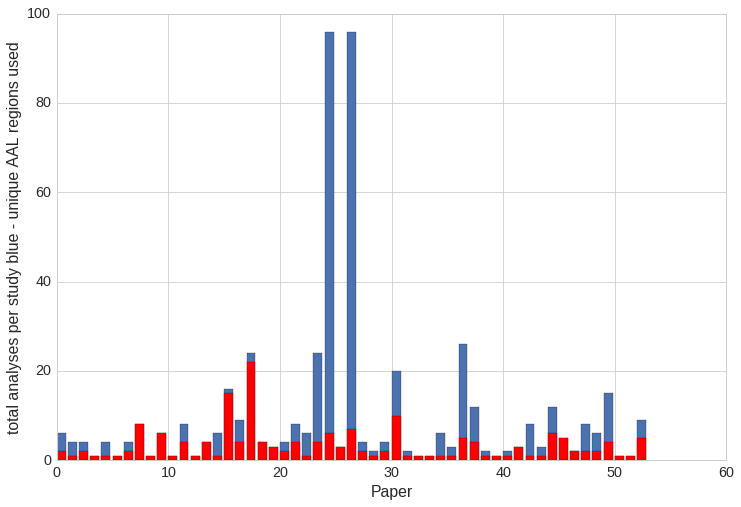

In [30]:
f,axarray=plt.subplots(1,1,figsize=(12,8))
x = np.arange(len(n_obs))
y = n_obs
axarray.bar(x,y)
y = n_rois
axarray.bar(x,y,color='r')
axarray.set_xlabel('Paper')
axarray.set_ylabel('total analyses per study blue - unique AAL regions used')
plt.savefig('../Figures/Supp/total_analyses_unique_rois.png')

In [31]:
np.sum(n_rois)/np.sum(n_obs)

0.34442270058708413